In [1]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

2023-10-01 16:44:53.686334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jhermosilla/robotica/demos_ws/devel/lib:/home/jhermosilla/ros_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2023-10-01 16:44:53.686364: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import matplotlib.pyplot as plt
from gym import Env, spaces
import numpy as np
import random
import math

from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout
from keras.models import load_model
from tabulate import tabulate
from keras import Sequential

In [3]:
np.random.seed(1)
tf.random.set_seed(1)

In [4]:
ring_buffer = np.array([0, 0, 0], dtype='float32')
ring_buffer[0] = 34.3
ring_buffer

array([34.3,  0. ,  0. ], dtype=float32)

In [5]:
class pouringEnv(Env):
  def __init__(self, path=None):
    self.action_space = spaces.Discrete(21) 
    self.state_shape = (2,)
    self.action_shape = self.action_space.n
    self.gamma=0.99 
    self.alpha=1e-4 
    self.learning_rate=0.01 

    # Container parameters
    self.h_c = 10.0
    self.r_c = 2.5
    self.h_l = self.h_c/2.0
    self.v_l = self.h_l*math.pi*self.r_c**2
    self.w_E = (2/3)*self.v_l
    
    self.alpha_lamda = 1.5708
    self.alpha_gamma = 0.6
    self.alpha_beta = 2.5
    self.ring_buffer = np.array([0, 0, 0], dtype='float32')
    
    self.alpha_spill = math.atan((self.h_c-self.h_l)/self.r_c)
    self.time_spill = -math.sqrt(-np.log(self.alpha_spill/self.alpha_lamda)/self.alpha_gamma) + self.alpha_beta
    self.v_goal = 0
    self.vt = 0
    self.time = np.arange(0,self.alpha_beta,0.0333)
    self.current_alpha = 0
    self.Dalpha_i = 0 

    # record observations
    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]
    self.discounted_rewards=[]
    self.total_rewards=[]
        
    if not path:
      self.model=self._create_model() 
    else:
      self.model=self.load_model(path)

  def _create_model(self):
    model=Sequential()
    model.add(Dense(2, input_shape=self.state_shape, activation="relu"))
    model.add(Dense(12, activation="relu"))
    model.add(Dense(self.action_shape, activation="softmax"))
    model.compile(loss="categorical_crossentropy",
            optimizer=Adam(lr=self.learning_rate))
    return model

  def hot_encode_action(self, action):
    '''encoding the actions into a binary list'''
    action_encoded=np.zeros(self.action_shape, np.float32)
    action_encoded[action]=1
    return action_encoded

  def remember(self, state, action, action_prob, reward):
    '''stores observations'''
    encoded_action=self.hot_encode_action(action)
    self.gradients.append(encoded_action-action_prob)
    self.states.append(state)
    self.rewards.append(reward)
    self.probs.append(action_prob)
    
  def get_action(self, state):
    state=state.reshape([1, state.shape[0]])
    action_probability_distribution=self.model.predict(state, verbose=0).flatten()
    action=np.random.choice(self.action_shape,1,p=action_probability_distribution)[0]
    return action, action_probability_distribution

  def get_alpha(self, time):
    return self.alpha_lamda*np.exp(-self.alpha_gamma*(time-self.alpha_beta)**2)

  def V_stack(self, itime):
    t = np.arange(0, itime, 0.0333)
    alphas = self.get_alpha(t)
    h1 = self.h_l + self.r_c*np.tan(alphas)
    h2 = self.h_c - h1
    
    if (h2[-1] >= 0.001):
        v = np.zeros((len(t)))
    else:
        a = self.time_spill/10.0
        h = (self.r_c)*np.exp(-((t-self.time_spill)**2)/(2*a**2))
        v = np.tan(alphas)*h**2

    return np.sum(v)

  def reset(self):
    time_i = np.random.choice(self.time)
    alpha_i = self.get_alpha(time_i)    
    self.current_alpha = alpha_i
    h1 = self.h_l + self.r_c*math.tan(alpha_i)
    h2 = self.h_c - h1
    k = np.random.choice(np.arange(0.5, 1.55, 0.05))
    self.v_goal = self.w_E*k
    
    if (h2 >= 0.001):
        h_i = -(self.h_c*math.sin(alpha_i+math.pi/2) - h1*math.sin(alpha_i+math.pi/2))
        v_i = 0
        v_0_i = 0
        v_i_n = 0
        d_i = (self.v_goal - v_0_i) - v_i
    else:
        a = self.time_spill/10.0
        h_i = (self.r_c)*np.exp(-((time_i-self.time_spill)**2)/(2*a**2))
        v_i = math.tan(alpha_i)*h_i**2
        v_i_n = self.w_E*(v_i/self.V_stack(self.alpha_beta))
        v_0_i = self.V_stack(time_i)
        d_i = (self.v_goal - v_0_i) - v_i

    print("---------Episode information---------")
    data = [[time_i, alpha_i, v_i, h_i]]
    print(tabulate(data, headers=["time_i", "alpha_i", "V_i", "h_i"]))
    print("-------------------------------------")
    data2 = [[self.time_spill, self.alpha_spill, self.v_goal]]
    print(tabulate(data2, headers=["time_s", "alpha_s", "Vg"]))
    print("----------------------------")
    data3 = [[self.v_l, self.h_c, self.r_c, self.h_l]]
    print(tabulate(data3, headers=["Vl", "hc", "rc", "hl"]))
    print("-------------------------")

    new_state = np.array([v_i_n, d_i])
    return new_state

  def next_step(self, action):
    action = action - 10
    if (action < 0):
      alpha_i = (-0.5149425*action**2)*(math.pi/180.0)
    else:
      alpha_i =  (0.05149425*action**2)*(math.pi/180.0)
    self.Dalpha_i = alpha_i
    self.current_alpha = alpha_i + self.current_alpha
    time_i = -math.sqrt(-np.log(self.current_alpha/self.alpha_lamda)/self.alpha_gamma) + self.alpha_beta
    h1 = self.h_l + self.r_c*math.tan(self.current_alpha)
    h2 = self.h_c - h1
    
    if (h2 >= 0.001):
        h_i = -(self.h_c*math.sin(self.current_alpha+math.pi/2) - h1*math.sin(self.current_alpha+math.pi/2))
        v_i = 0
        v_0_i = 0
        v_i_n = 0
        d_i = (self.v_goal - v_0_i) - v_i
    else:
        a = self.time_spill/10.0
        h_i = (self.r_c)*np.exp(-((time_i-self.time_spill)**2)/(2*a**2))
        v_i = math.tan(self.current_alpha)*h_i**2
        v_i_n = self.w_E*(v_i/self.V_stack(self.alpha_beta))
        v_0_i = self.V_stack(time_i)
        d_i = (self.v_goal - v_0_i) - v_i
    
    #print("v_i+1: %3.2f, d_i+1: %3.2f, a_i+1: %3.2f" % (v_i_n, d_i, self.current_alpha))
    new_state = np.array([v_i_n, d_i])
    done = False
    deltaV = self.v_goal - (v_0_i+v_i)

    if (self.ring_buffer[0]*self.ring_buffer[1] >= 0):
        Delta = 1
    else:
        Delta = -1

    if (d_i > 0):
        Reward = Delta + v_i**2 - math.log(d_i/self.v_goal)
    else:
        Reward = Delta + v_i**2 - 100.0
        
    # Shift buffer
    # Di,   Di-1,  Di-1
    self.ring_buffer[2] = self.ring_buffer[1] 
    # Di,   Di,    Di-1
    self.ring_buffer[1] = self.ring_buffer[0]
    # Di+1, Di,    Di-1 
    self.ring_buffer[0] = self.Dalpha_i
            
    if ((deltaV) <= 0.5):
      done = True
      print("Done!")
    return new_state, done, Reward

  def get_discounted_rewards(self, rewards): 
    '''Use gamma to calculate the total reward discounting for rewards
    Following - \gamma ^ t * Gt'''

    discounted_rewards=[]
    cumulative_total_return=0
    for reward in rewards[::-1]:      
        cumulative_total_return=(cumulative_total_return*self.gamma)+reward
        discounted_rewards.insert(0, cumulative_total_return)

        mean_rewards=np.mean(discounted_rewards)
        std_rewards=np.std(discounted_rewards)
        norm_discounted_rewards=(discounted_rewards-mean_rewards)/(std_rewards+1e-7) # avoiding zero div
    return norm_discounted_rewards
    
  def update_policy(self):
    '''Updates the policy network using the NN model.
    This function is used after the MC sampling is done - following
    \delta \theta = \alpha * gradient + log pi'''
    states=np.vstack(self.states)
    gradients=np.vstack(self.gradients)
    rewards=np.vstack(self.rewards)
    discounted_rewards=self.get_discounted_rewards(rewards)
    gradients*=discounted_rewards
    gradients=self.alpha*np.vstack([gradients])+self.probs
    print("delta=",self.probs-gradients)
    history=self.model.train_on_batch(states, gradients)
    self.states, self.probs, self.gradients, self.rewards=[], [], [], []
    return history
    
  def train(self, episodes, rollout_n=1):
    total_rewards=np.zeros(episodes)
    for episode in range(episodes):
        state = self.reset()
        done = False
        episode_reward=0
        while not done:
            action, prob = self.get_action(state)
            next_state, done, reward = self.next_step(action)
            self.remember(state, action, prob, reward)
            state = next_state
            episode_reward+=reward
            if done:
                if episode%rollout_n==0:
                    history=self.update_policy()
        total_rewards[episode]=episode_reward
    self.total_rewards=total_rewards

In [6]:
"""
agent = pouringEnv()
state = agent.reset()
action, prob = agent.get_action(state)
done=False
while not done:
  action, prob = agent.get_action(state)
  next_state, done, deltaV = agent.next_step(action)
  state = next_state
"""

'\nagent = pouringEnv()\nstate = agent.reset()\naction, prob = agent.get_action(state)\ndone=False\nwhile not done:\n  action, prob = agent.get_action(state)\n  next_state, done, deltaV = agent.next_step(action)\n  state = next_state\n'

In [14]:
agent = pouringEnv()
agent.train(2, 1)

---------Episode information---------
  time_i    alpha_i    V_i       h_i
--------  ---------  -----  --------
  0.3663   0.102282      0  -4.71861
-------------------------------------
  time_s    alpha_s       Vg
--------  ---------  -------
 1.73646    1.10715  78.5398
----------------------------
     Vl    hc    rc    hl
-------  ----  ----  ----
98.1748    10   2.5     5
-------------------------
Done!
delta= [[-5.68878278e-13 -1.27915210e-20 -3.87782271e-21 ... -1.05138120e-13
  -3.41220108e-15 -2.15569885e-19]
 [-5.67546010e-13 -1.27650512e-20 -3.87120527e-21 ... -1.04916076e-13
  -3.40526218e-15 -2.15146369e-19]
 [-5.66213743e-13 -1.27385814e-20 -3.86458782e-21 ... -1.04694031e-13
  -3.39832329e-15 -2.14722852e-19]
 ...
 [-1.15534249e-11 -5.07542142e-18 -1.88210721e-18 ... -2.84217094e-12
  -1.64424030e-13 -5.31259065e-17]
 [-1.52198254e-11 -6.75254666e-18 -2.50552346e-18 ... -3.74456022e-12
  -2.17048601e-13 -7.05273513e-17]
 [-6.52298331e-06 -1.54785812e-06 -2.20835209e-05 

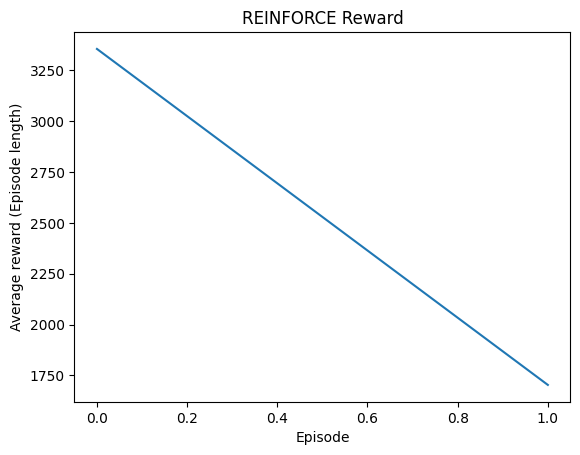

In [15]:
plt.title('REINFORCE Reward')
plt.xlabel('Episode')
plt.ylabel('Average reward (Episode length)')
plt.plot(agent.total_rewards)
plt.show()